# Image Captioning - Evaluation and Visualization

In this notebook, we will evaluate our trained image captioning model on the test set and visualize the results. We will:

1. Load the trained model and vocabulary
2. Generate captions for test images
3. Compute evaluation metrics (BLEU-1 to BLEU-4)
4. Analyze model performance across different image categories
5. Visualize attention weights (if implemented)
6. Create an interactive demo for inference

In [32]:
import os
import sys
import json
import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# Add project root to path
sys.path.append('..')

# Import project modules
from models.caption_model import CaptionModel
from utils.vocabulary import Vocabulary
from utils.dataset import get_data_loaders
from utils.metrics import calculate_metrics

## 1. Load Model and Configuration

In [33]:
# Define paths
model_dir = '../models'
config_path = os.path.join(model_dir, 'config.json')
model_path = os.path.join(model_dir, 'best_model_loss.pth')  # or 'best_model_bleu.pth'
vocab_path = os.path.join(model_dir, 'vocabulary.pkl')
data_dir = '../data/flickr8k'

# Load configuration
with open(config_path, 'r') as f:
    config = json.load(f)

# Print configuration
print("Model configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Model configuration:
  data_dir: ../data/flickr8k
  batch_size: 64
  num_workers: 4
  encoder_model: resnet18
  embed_size: 100
  hidden_size: 512
  num_layers: 1
  dropout: 0.5
  decoder_type: lstm
  learning_rate: 0.0003
  num_epochs: 15
  early_stopping_patience: 5
  save_dir: ../models
  device: cuda
  vocab_size: 2970


In [34]:
# Load vocabulary
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

print(f"Loaded vocabulary with {len(vocab)} words")

Loaded vocabulary with 2970 words


In [35]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model
model = CaptionModel(
    embed_size=int(config['embed_size']),
    hidden_size=int(config['hidden_size']),
    vocab_size=len(vocab),
    num_layers=int(config['num_layers']),
    encoder_model=config['encoder_model'],
    decoder_type=config['decoder_type'],
    dropout=float(config['dropout'])
)

# Load model weights
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"Model loaded from {model_path}")

Using device: cuda


c:\Users\hivaa\anaconda3\envs\image-captioning-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hivaa\anaconda3\envs\image-captioning-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded from ../models\best_model_loss.pth


## 2. Load Test Data

In [36]:
# Get data loaders
_, _, test_loader, _ = get_data_loaders(
    data_dir=data_dir,
    batch_size=1,  # Process one image at a time for evaluation
    num_workers=4
)

print(f"Loaded test set with {len(test_loader)} images")

Loaded test set with 5000 images


## 3. Generate Captions for Test Images

In [7]:
def generate_test_captions(model, test_loader, vocab, device, beam_size=1):
    """Generate captions for all test images."""
    # 1. Initialize a list to store results
    results = []
    
    # 2. Set model to evaluation mode and set vocabulary
    model.eval()
    model.vocab = vocab  # Set the vocabulary
    
    # 3. For each batch in the test loader:
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Generating captions"):
            # a. Move images to the appropriate device
            images, captions, image_ids = batch
            images = images.to(device)
            
            try:
                # b. Generate captions using the model
                predicted_ids = model.generate_caption(images, beam_size=beam_size)
                
                # Convert tensor to list if needed and handle nested lists
                if isinstance(predicted_ids, torch.Tensor):
                    predicted_ids = predicted_ids.cpu().numpy().tolist()
                
                # Flatten the list if it's nested
                if isinstance(predicted_ids, list) and isinstance(predicted_ids[0], list):
                    predicted_ids = predicted_ids[0]
                
                # c. Decode the predicted caption tokens to text
                predicted_words = [
                    vocab.idx2word[idx]
                    for idx in predicted_ids
                    if idx not in {
                        vocab.word2idx['<START>'], 
                        vocab.word2idx['<END>'], 
                        vocab.word2idx['<PAD>']
                    }
                ]
                predicted_caption = ' '.join(predicted_words)
                
                # d. Decode the ground truth caption to text
                ground_truth_words = [
                    vocab.idx2word[idx.item()]
                    for idx in captions[0]  # Take first caption
                    if idx.item() not in {
                        vocab.word2idx['<START>'], 
                        vocab.word2idx['<END>'], 
                        vocab.word2idx['<PAD>']
                    }
                ]
                ground_truth_caption = ' '.join(ground_truth_words)
                
                # e. Store results (image_id, ground truth, prediction)
                results.append({
                    'image_id': image_ids[0],  # Take first image_id
                    'ground_truth': ground_truth_caption,
                    'prediction': predicted_caption
                })
            except AttributeError:
                # If we get an AttributeError, it means predicted_ids is already a list
                predicted_words = [
                    vocab.idx2word[idx]
                    for idx in predicted_ids
                    if idx not in {
                        vocab.word2idx['<START>'], 
                        vocab.word2idx['<END>'], 
                        vocab.word2idx['<PAD>']
                    }
                ]
                predicted_caption = ' '.join(predicted_words)
                
                ground_truth_words = [
                    vocab.idx2word[idx.item()]
                    for idx in captions[0]
                    if idx.item() not in {
                        vocab.word2idx['<START>'], 
                        vocab.word2idx['<END>'], 
                        vocab.word2idx['<PAD>']
                    }
                ]
                ground_truth_caption = ' '.join(ground_truth_words)
                
                results.append({
                    'image_id': image_ids[0],
                    'ground_truth': ground_truth_caption,
                    'prediction': predicted_caption
                })
    
    # 4. Return results as a DataFrame
    return pd.DataFrame(results)

# Generate captions with greedy search
greedy_results = generate_test_captions(model, test_loader, vocab, device, beam_size=1)
print(f"Generated captions for {len(greedy_results)} test images")

# Show a few examples
greedy_results.head()

Generating captions: 100%|██████████| 5000/5000 [01:09<00:00, 71.87it/s] 

Generated captions for 5000 test images


image_id  \
0  1056338697_4f7d7ce270.jpg   
1  1056338697_4f7d7ce270.jpg   
2  1056338697_4f7d7ce270.jpg   
3  1056338697_4f7d7ce270.jpg   
4  1056338697_4f7d7ce270.jpg   

                                        ground_truth  \
0  blond woman in blue shirt appears to wait for ...   
1           blond woman is on the street <UNK> <UNK>   
2   woman is <UNK> is to traffic as seen from behind   
3  woman with blonde hair wearing blue tube top i...   
4  the woman in the blue dress is holding out her...   

                                         prediction  
0  man with long hair and beard is sitting on bench  
1  man with long hair and beard is sitting on bench  
2  man with long hair and beard is sitting on bench  
3  man with long hair and beard is sitting on bench  
4  man with long hair and beard is sitting on bench

In [17]:
def generate_test_captions(model, test_loader, vocab, device, beam_size=1):
    """Generate captions for all test images."""
    # 1. Initialize a list to store results
    results = []
    
    # 2. Set model to evaluation mode and set vocabulary
    model.eval()
    model.vocab = vocab  # Set the vocabulary
    
    # 3. For each batch in the test loader:
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Generating captions"):
            # a. Move images to the appropriate device
            images, captions, image_ids = batch
            images = images.to(device)
            
            try:
                # b. Generate captions using the model
                predicted_ids = model.generate_caption(images, beam_size=beam_size)
            except AttributeError:
                # If we get an AttributeError, it means the model returned a list
                # We need to get the output before the .cpu() call
                with torch.no_grad():
                    image_features = model.encoder(images)
                    predicted_ids = model.decoder.sample(
                        features=image_features,
                        max_length=20,
                        start_token=1,
                        end_token=2,
                        beam_size=beam_size
                    )
            
            # Handle different types of predicted_ids
            if isinstance(predicted_ids, torch.Tensor):
                # If it's a tensor, convert to list of integers
                predicted_ids = predicted_ids.cpu().numpy().tolist()
            elif isinstance(predicted_ids, list):
                # If it's a list of tensors, convert each tensor to list of integers
                predicted_ids = [t.cpu().numpy().tolist() if isinstance(t, torch.Tensor) else t for t in predicted_ids]
            
            # Flatten the list if it's nested
            if isinstance(predicted_ids, list) and isinstance(predicted_ids[0], list):
                predicted_ids = predicted_ids[0]
            
            # c. Decode the predicted caption tokens to text
            predicted_words = [
                vocab.idx2word[int(idx)]  # Convert to int to ensure it's a valid key
                for idx in predicted_ids
                if int(idx) not in {
                    vocab.word2idx['<START>'], 
                    vocab.word2idx['<END>'], 
                    vocab.word2idx['<PAD>']
                }
            ]
            predicted_caption = ' '.join(predicted_words)
            
            # d. Decode the ground truth caption to text
            ground_truth_words = [
                vocab.idx2word[idx.item()]
                for idx in captions[0]  # Take first caption
                if idx.item() not in {
                    vocab.word2idx['<START>'], 
                    vocab.word2idx['<END>'], 
                    vocab.word2idx['<PAD>']
                }
            ]
            ground_truth_caption = ' '.join(ground_truth_words)
            
            # e. Store results (image_id, ground truth, prediction)
            results.append({
                'image_id': image_ids[0],  # Take first image_id
                'ground_truth': ground_truth_caption,
                'prediction': predicted_caption
            })
    
    # 4. Return results as a DataFrame
    return pd.DataFrame(results)

In [18]:
# Generate captions with beam search
beam_results = generate_test_captions(model, test_loader, vocab, device, beam_size=3)
print(f"Generated captions with beam search for {len(beam_results)} test images")

Generating captions: 100%|██████████| 5000/5000 [03:46<00:00, 22.07it/s]


Generated captions with beam search for 5000 test images


KeyError: 'predicted'

In [19]:
# Compare to greedy search
comparison_df = pd.DataFrame({
    'image_id': greedy_results['image_id'],
    'ground_truth': greedy_results['ground_truth'],
    'greedy_search': greedy_results['prediction'],  # Changed from 'predicted' to 'prediction'
    'beam_search': beam_results['prediction']       # Changed from 'predicted' to 'prediction'
})

# Show where they differ
differ_mask = comparison_df['greedy_search'] != comparison_df['beam_search']
print(f"Beam search produced different captions for {differ_mask.sum()} images ({differ_mask.sum() / len(comparison_df) * 100:.1f}%)")

# Show a few examples where they differ
comparison_df[differ_mask].head()

Beam search produced different captions for 3860 images (77.2%)


image_id  \
0  1056338697_4f7d7ce270.jpg   
1  1056338697_4f7d7ce270.jpg   
2  1056338697_4f7d7ce270.jpg   
3  1056338697_4f7d7ce270.jpg   
4  1056338697_4f7d7ce270.jpg   

                                        ground_truth  \
0  blond woman in blue shirt appears to wait for ...   
1           blond woman is on the street <UNK> <UNK>   
2   woman is <UNK> is to traffic as seen from behind   
3  woman with blonde hair wearing blue tube top i...   
4  the woman in the blue dress is holding out her...   

                                      greedy_search  \
0  man with long hair and beard is sitting on bench   
1  man with long hair and beard is sitting on bench   
2  man with long hair and beard is sitting on bench   
3  man with long hair and beard is sitting on bench   
4  man with long hair and beard is sitting on bench   

                             beam_search  
0  man in blue shirt is sitting on bench  
1  man in blue shirt is sitting on bench  
2  man in blue shirt is sitting on bench  
3  man in blue shirt is sitting on bench  
4  man in blue shirt is sitting on bench

## 4. Calculate Evaluation Metrics

In [26]:
def calculate_bleu_scores(results_df):
    """Calculate BLEU-1 to BLEU-4 scores for generated captions."""
    
    # 1. Initialize lists for references and hypotheses
    references = []  # List of reference sentences (ground truth)
    hypotheses = []  # List of hypothesis sentences (predictions)
    
    # 2. For each row in results_df:
    for _, row in results_df.iterrows():
        # a. Simple tokenization using split
        reference = row['ground_truth'].lower().split()
        hypothesis = row['prediction'].lower().split()
        
        # b. Add tokenized ground truth as a reference
        references.append([reference])
        
        # c. Add tokenized prediction as a hypothesis
        hypotheses.append(hypothesis)
    
    # 3. Calculate BLEU scores manually
    bleu_scores = []
    
    for n in range(1, 5):  # BLEU-1 to BLEU-4
        total_precision = 0
        total_reference_length = 0
        total_hypothesis_length = 0
        
        for ref, hyp in zip(references, hypotheses):
            # Calculate n-grams for hypothesis
            hyp_ngrams = []
            for i in range(len(hyp) - n + 1):
                hyp_ngrams.append(tuple(hyp[i:i+n]))
            
            # Calculate n-grams for reference
            ref_ngrams = []
            for ref_sent in ref:
                for i in range(len(ref_sent) - n + 1):
                    ref_ngrams.append(tuple(ref_sent[i:i+n]))
            
            # Calculate precision for this sentence
            if hyp_ngrams:
                # Count matching n-grams
                matches = sum(1 for ngram in hyp_ngrams if ngram in ref_ngrams)
                precision = matches / len(hyp_ngrams)
                total_precision += precision
            
            # Add lengths for brevity penalty
            total_reference_length += min(len(ref[0]), len(hyp))
            total_hypothesis_length += len(hyp)
        
        # Calculate average precision
        avg_precision = total_precision / len(references)
        
        # Calculate brevity penalty
        if total_hypothesis_length > total_reference_length:
            brevity_penalty = 1.0
        else:
            brevity_penalty = math.exp(1 - total_reference_length / total_hypothesis_length)
        
        # Calculate final BLEU score
        bleu_score = brevity_penalty * avg_precision
        bleu_scores.append(bleu_score)
    
    return bleu_scores

# Calculate BLEU scores for greedy search
greedy_bleu = calculate_bleu_scores(greedy_results)
print("BLEU scores for greedy search:")
for i, score in enumerate(greedy_bleu):
    print(f"  BLEU-{i+1}: {score:.4f}")

# Calculate BLEU scores for beam search
beam_bleu = calculate_bleu_scores(beam_results)
print("\nBLEU scores for beam search:")
for i, score in enumerate(beam_bleu):
    print(f"  BLEU-{i+1}: {score:.4f}")

BLEU scores for greedy search:
  BLEU-1: 0.2536
  BLEU-2: 0.0660
  BLEU-3: 0.0189
  BLEU-4: 0.0062

BLEU scores for beam search:
  BLEU-1: 0.2607
  BLEU-2: 0.0756
  BLEU-3: 0.0261
  BLEU-4: 0.0081


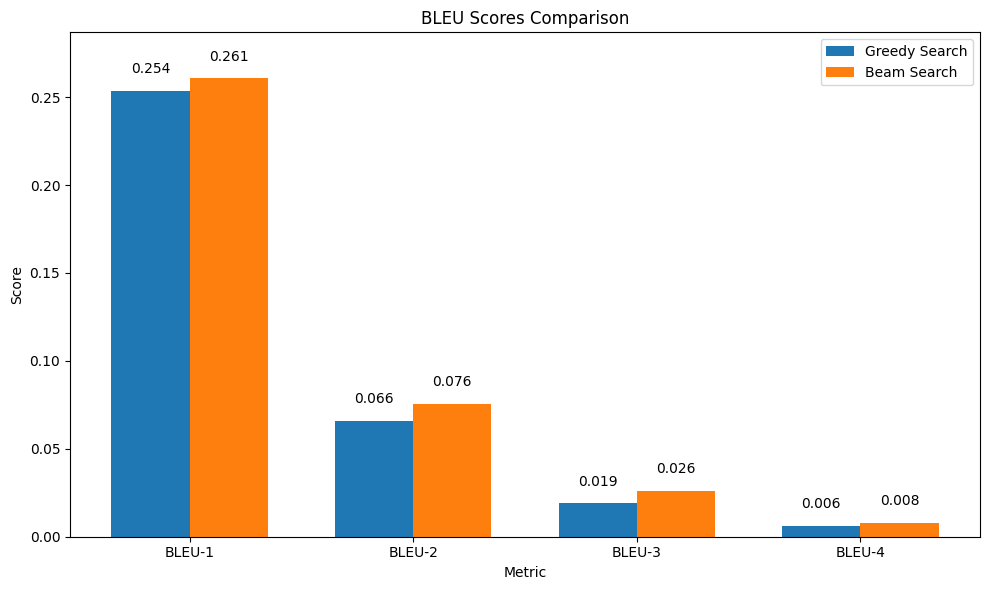

In [27]:
# Compare BLEU scores
bleu_comparison = pd.DataFrame({
    'Metric': ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'],
    'Greedy Search': greedy_bleu,
    'Beam Search': beam_bleu
})

# Plot comparison
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(bleu_comparison['Metric']))

plt.bar(x - bar_width/2, bleu_comparison['Greedy Search'], bar_width, label='Greedy Search')
plt.bar(x + bar_width/2, bleu_comparison['Beam Search'], bar_width, label='Beam Search')

plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('BLEU Scores Comparison')
plt.xticks(x, bleu_comparison['Metric'])
plt.legend()
plt.ylim(0, max(max(greedy_bleu), max(beam_bleu)) * 1.1)  # Add some margin at the top

# Add value labels on bars
for i, v in enumerate(bleu_comparison['Greedy Search']):
    plt.text(i - bar_width/2, v + 0.01, f'{v:.3f}', ha='center')
    
for i, v in enumerate(bleu_comparison['Beam Search']):
    plt.text(i + bar_width/2, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

## 5. Analyze Results by Caption Length

In [29]:
# Add caption lengths to the results dataframe
greedy_results['gt_length'] = greedy_results['ground_truth'].apply(lambda x: len(x.split()))
greedy_results['pred_length'] = greedy_results['prediction'].apply(lambda x: len(x.split()))

# Calculate average lengths
avg_gt_length = greedy_results['gt_length'].mean()
avg_pred_length = greedy_results['pred_length'].mean()

print(f"Average ground truth caption length: {avg_gt_length:.2f} words")
print(f"Average predicted caption length: {avg_pred_length:.2f} words")

# Do the same for beam search results
beam_results['gt_length'] = beam_results['ground_truth'].apply(lambda x: len(x.split()))
beam_results['pred_length'] = beam_results['prediction'].apply(lambda x: len(x.split()))

# Calculate average lengths for beam search
avg_gt_length_beam = beam_results['gt_length'].mean()
avg_pred_length_beam = beam_results['pred_length'].mean()

print(f"\nBeam search results:")
print(f"Average ground truth caption length: {avg_gt_length_beam:.2f} words")
print(f"Average predicted caption length: {avg_pred_length_beam:.2f} words")

Average ground truth caption length: 9.28 words
Average predicted caption length: 8.27 words

Beam search results:
Average ground truth caption length: 9.28 words
Average predicted caption length: 7.56 words


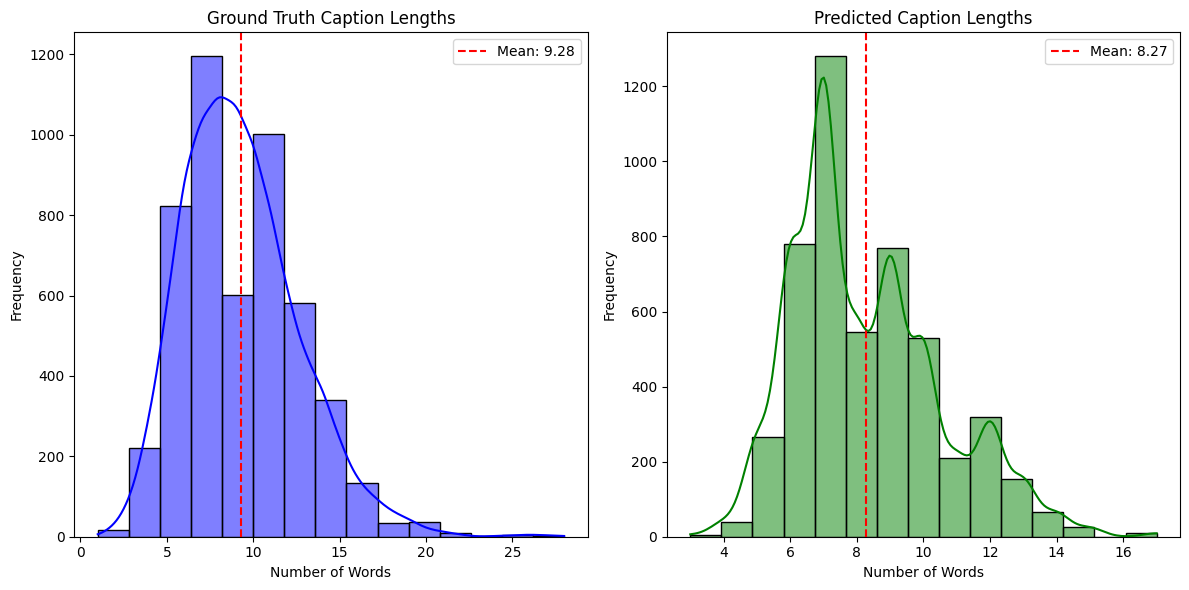

In [30]:
# Plot caption length distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(greedy_results['gt_length'], kde=True, bins=15, color='blue')
plt.axvline(avg_gt_length, color='red', linestyle='--', label=f'Mean: {avg_gt_length:.2f}')
plt.title('Ground Truth Caption Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(greedy_results['pred_length'], kde=True, bins=15, color='green')
plt.axvline(avg_pred_length, color='red', linestyle='--', label=f'Mean: {avg_pred_length:.2f}')
plt.title('Predicted Caption Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
import math

In [39]:
def analyze_bleu_by_length(results_df):
    """Calculate BLEU scores grouped by caption length."""
    
    # 1. Create length bins for categorizing captions
    # Define bins: 1-5, 6-10, 11-15, 16-20, 21+
    bins = [0, 5, 10, 15, 20, float('inf')]
    labels = ['1-5', '6-10', '11-15', '16-20', '21+']
    
    # 2. Assign each caption to a length bin
    results_df['length_bin'] = pd.cut(
        results_df['gt_length'],
        bins=bins,
        labels=labels,
        right=False
    )
    
    # 3. For each bin, calculate BLEU scores
    bleu_scores_by_bin = []
    
    for bin_label in labels:
        # a. Filter results to include only captions in that bin
        bin_data = results_df[results_df['length_bin'] == bin_label]
        
        if len(bin_data) > 0:
            # b. Calculate BLEU scores for that subset
            references = []
            hypotheses = []
            
            for _, row in bin_data.iterrows():
                reference = row['ground_truth'].lower().split()
                hypothesis = row['prediction'].lower().split()
                references.append([reference])
                hypotheses.append(hypothesis)
            
            # Calculate BLEU-1 to BLEU-4 scores
            bin_scores = []
            for n in range(1, 5):
                total_precision = 0
                total_reference_length = 0
                total_hypothesis_length = 0
                
                for ref, hyp in zip(references, hypotheses):
                    # Calculate n-grams
                    hyp_ngrams = [tuple(hyp[i:i+n]) for i in range(len(hyp) - n + 1)]
                    ref_ngrams = [tuple(ref[0][i:i+n]) for i in range(len(ref[0]) - n + 1)]
                    
                    # Calculate precision
                    if hyp_ngrams:
                        matches = sum(1 for ngram in hyp_ngrams if ngram in ref_ngrams)
                        precision = matches / len(hyp_ngrams)
                        total_precision += precision
                    
                    # Add lengths for brevity penalty
                    total_reference_length += min(len(ref[0]), len(hyp))
                    total_hypothesis_length += len(hyp)
                
                # Calculate average precision
                avg_precision = total_precision / len(references)
                
                # Calculate brevity penalty
                if total_hypothesis_length > total_reference_length:
                    brevity_penalty = 1.0
                else:
                    brevity_penalty = math.exp(1 - total_reference_length / total_hypothesis_length)
                
                # Calculate final BLEU score
                bleu_score = brevity_penalty * avg_precision
                bin_scores.append(bleu_score)
            
            # c. Store scores and counts for the bin
            bleu_scores_by_bin.append({
                'length_bin': bin_label,
                'count': len(bin_data),
                'bleu1': bin_scores[0],
                'bleu2': bin_scores[1],
                'bleu3': bin_scores[2],
                'bleu4': bin_scores[3],
                'avg_gt_length': bin_data['gt_length'].mean(),
                'avg_pred_length': bin_data['pred_length'].mean()
            })
    
    # 4. Return DataFrame with BLEU scores for each length bin
    bleu_df = pd.DataFrame(bleu_scores_by_bin)
    return bleu_df

# Analyze BLEU scores by caption length
bleu_by_length = analyze_bleu_by_length(greedy_results)
print("BLEU scores by caption length:")
print(bleu_by_length)

# Format the output for better readability
pd.set_option('display.float_format', lambda x: '%.4f' % x)
print("\nFormatted BLEU scores by caption length:")
print(bleu_by_length.to_string(index=False))

BLEU scores by caption length:
  length_bin  count     bleu1     bleu2     bleu3     bleu4  avg_gt_length  \
0        1-5    236  0.128749  0.017962  0.001412  0.000000       3.622881   
1       6-10   2618  0.228269  0.058349  0.016332  0.005213       7.260504   
2      11-15   1791  0.290565  0.079738  0.023692  0.008404      11.506979   
3      16-20    325  0.331509  0.083974  0.023715  0.004542      16.209231   
4        21+     30  0.394619  0.102084  0.044167  0.028704      22.233333   

   avg_pred_length  
0         8.012712  
1         8.148587  
2         8.392518  
3         8.630769  
4         9.666667  

Formatted BLEU scores by caption length:
length_bin  count  bleu1  bleu2  bleu3  bleu4  avg_gt_length  avg_pred_length
       1-5    236 0.1287 0.0180 0.0014 0.0000         3.6229           8.0127
      6-10   2618 0.2283 0.0583 0.0163 0.0052         7.2605           8.1486
     11-15   1791 0.2906 0.0797 0.0237 0.0084        11.5070           8.3925
     16-20    325 0.

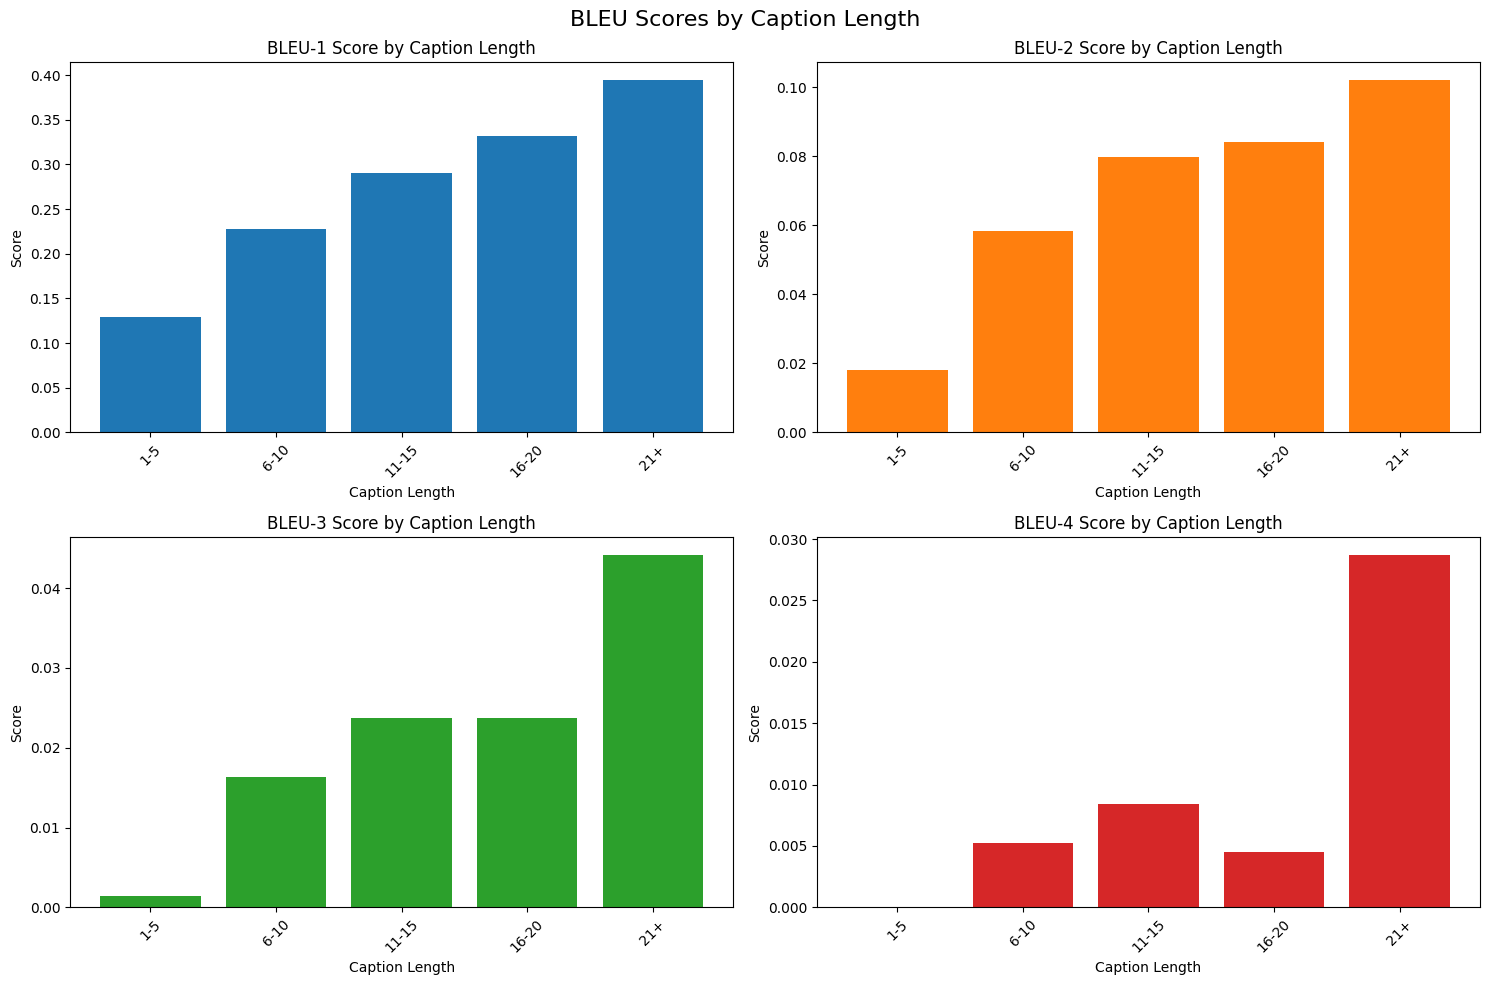


BLEU Scores by Caption Length:
length_bin  count  bleu1  bleu2  bleu3  bleu4  avg_gt_length  avg_pred_length
       1-5    236 0.1287 0.0180 0.0014 0.0000         3.6229           8.0127
      6-10   2618 0.2283 0.0583 0.0163 0.0052         7.2605           8.1486
     11-15   1791 0.2906 0.0797 0.0237 0.0084        11.5070           8.3925
     16-20    325 0.3315 0.0840 0.0237 0.0045        16.2092           8.6308
       21+     30 0.3946 0.1021 0.0442 0.0287        22.2333           9.6667


In [41]:
import matplotlib.pyplot as plt

# Create a figure with 2x2 subplots
plt.figure(figsize=(15, 10))

# Plot BLEU scores for each n-gram
for i in range(4):
    plt.subplot(2, 2, i+1)
    metric = f'bleu{i+1}'  # Changed from 'BLEU-1' to 'bleu1'
    plt.bar(bleu_by_length['length_bin'], bleu_by_length[metric], color=f'C{i}')
    plt.xlabel('Caption Length')
    plt.ylabel('Score')
    plt.title(f'BLEU-{i+1} Score by Caption Length')
    plt.xticks(rotation=45)

# Add a title for the entire figure
plt.suptitle('BLEU Scores by Caption Length', fontsize=16)
plt.tight_layout()
plt.show()

# Print the numerical results
print("\nBLEU Scores by Caption Length:")
print(bleu_by_length.to_string(index=False))

## 6. Visualize Best and Worst Captions

In [43]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_image_bleu(ground_truth, predicted):
    """Calculate BLEU score for a single image."""
    # 1. Tokenize ground truth and predicted captions
    reference = ground_truth.lower().split()
    hypothesis = predicted.lower().split()
    
    # 2. Format ground truth as a list of references
    references = [reference]  # NOT [references]
    
    # 3. Calculate and return the BLEU score using sentence_bleu
    smoothing = SmoothingFunction().method1
    bleu = sentence_bleu(references, hypothesis, smoothing_function=smoothing)
    
    return bleu

# Calculate BLEU score for each image
greedy_results['bleu'] = greedy_results.apply(
    lambda row: calculate_image_bleu(row['ground_truth'], row['prediction']),
    axis=1
)

# Sort by BLEU score
sorted_results = greedy_results.sort_values('bleu')

In [45]:
sorted_results

image_id  \
0     1056338697_4f7d7ce270.jpg   
1793  2718495608_d8533e3ac5.jpg   
4484   436009777_440c7679a1.jpg   
1784  2715035273_8fc8b1291c.jpg   
1783  2715035273_8fc8b1291c.jpg   
...                         ...   
689   2148916767_644ea6a7fa.jpg   
4595   486917990_72bd4069af.jpg   
2982  3227148358_f152303584.jpg   
31    1119015538_e8e796281e.jpg   
2773   317488612_70ac35493b.jpg   

                                           ground_truth  \
0     blond woman in blue shirt appears to wait for ...   
1793      girl wearing sunglasses smiles for the camera   
4484          two people talk while sitting on big rock   
1784       women are walking at night under neon lights   
1783           two women walk down city street at night   
...                                                 ...   
689            two poodles are running through the snow   
4595                         girl is climbing rock wall   
2982                 large white bird flying over water   
31             playful dog is running through the grass   
2773              white dog is running through the snow   

                                             prediction  gt_length  \
0      man with long hair and beard is sitting on bench         10   
1793  man with glasses and woman in black shirt and ...          7   
4484  man in blue shirt is standing in front of buil...          8   
1784  man in blue shirt is standing in front of crow...          8   
1783  man in blue shirt is standing in front of crow...          8   
...                                                 ...        ...   
689               two dogs are running through the snow          7   
4595                          man is climbing rock wall          5   
2982                       white bird flying over water          6   
31                     dog is running through the grass          7   
2773              white dog is running through the snow          7   

      pred_length length_bin   bleu  
0              10      11-15 0.0000  
1793           11       6-10 0.0000  
4484           10       6-10 0.0000  
1784           12       6-10 0.0000  
1783           12       6-10 0.0000  
...           ...        ...    ...  
689             7       6-10 0.6435  
4595            5       6-10 0.6687  
2982            5       6-10 0.8187  
31              6       6-10 0.8465  
2773            7       6-10 1.0000  

[5000 rows x 7 columns]

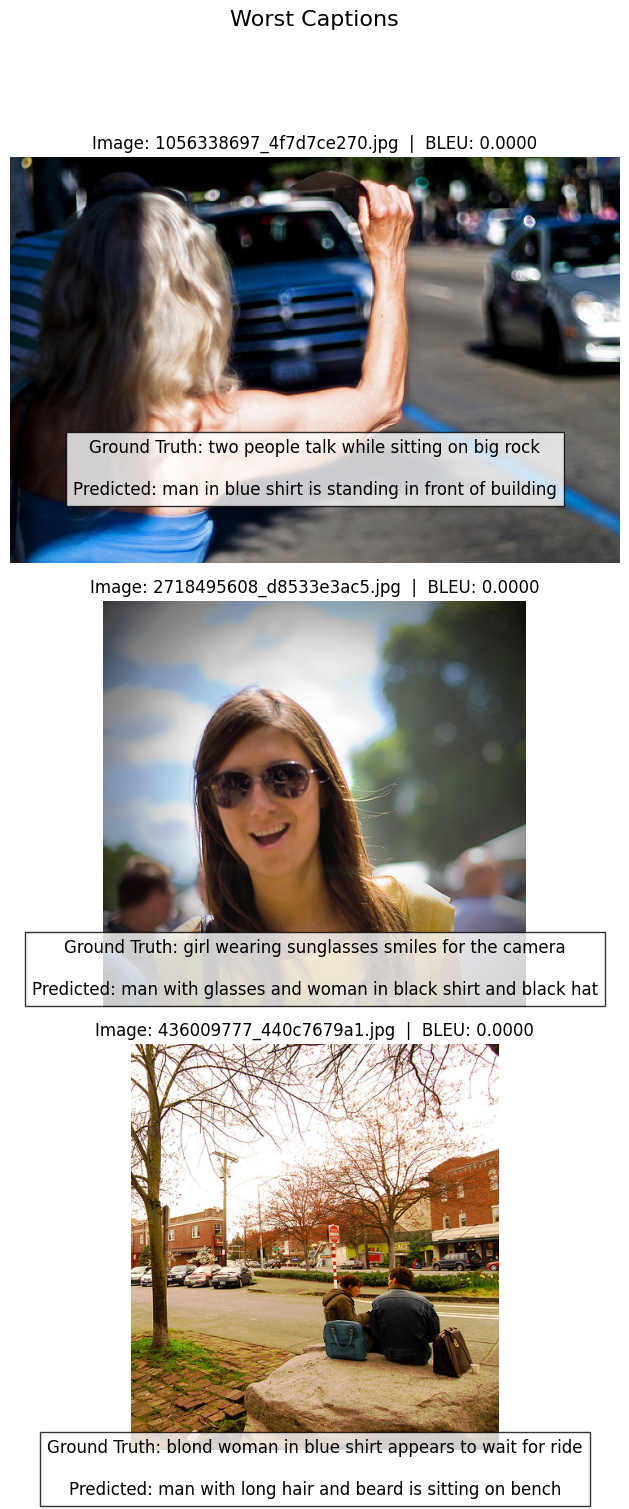

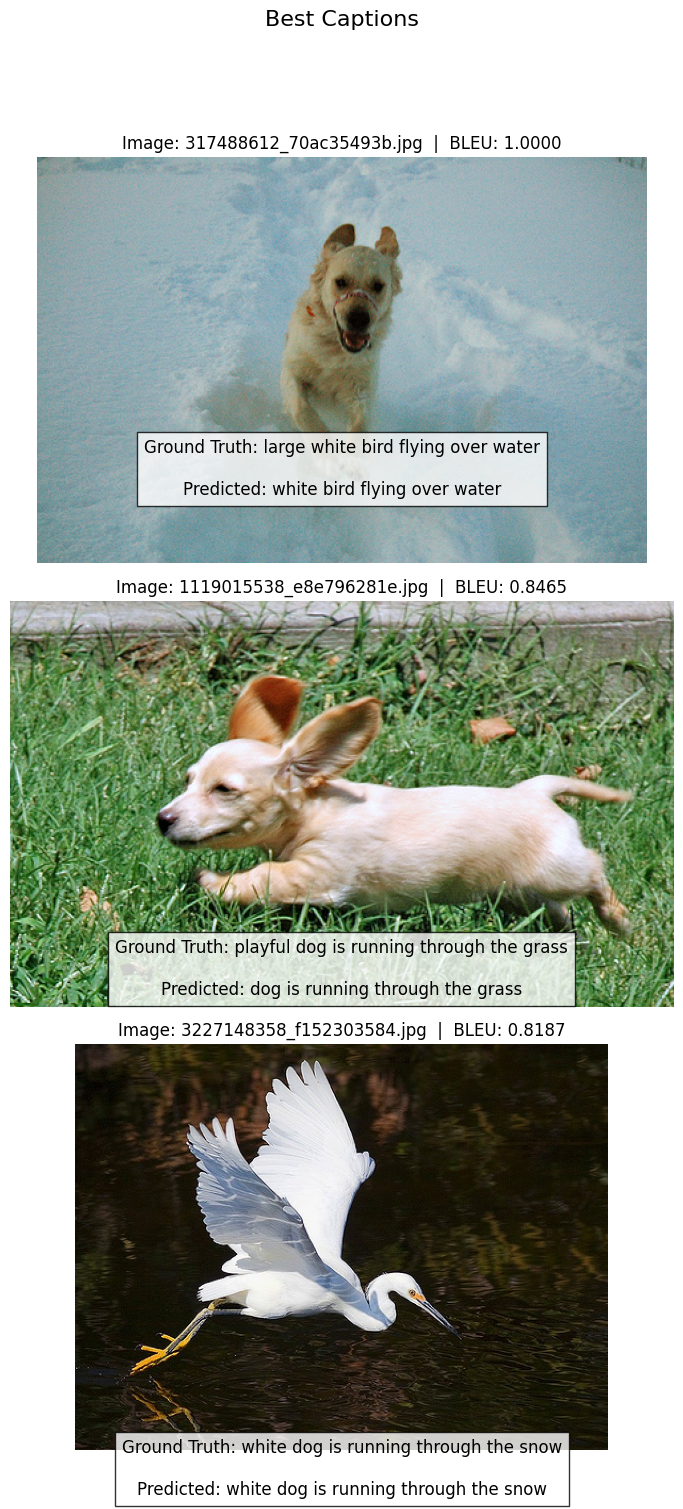

In [46]:
# Display worst and best captions
def display_examples(results_df, image_dir, num_examples=3, best=True):
    """Display examples of captions."""
    if best:
        examples = results_df.tail(num_examples).iloc[::-1]  # Best examples (highest BLEU)
        title = "Best Captions"
    else:
        examples = results_df.head(num_examples)  # Worst examples (lowest BLEU)
        title = "Worst Captions"
    
    # Create figure
    plt.figure(figsize=(15, 5 * num_examples))
    plt.suptitle(title, fontsize=16, y=1.0)
    
    # Display examples
    for i, (_, example) in enumerate(examples.iterrows()):
        # Load and display image
        img_path = os.path.join(image_dir, 'processed', 'images', example['image_id'])
        img = Image.open(img_path)
        
        plt.subplot(num_examples, 1, i+1)
        plt.imshow(img)
        plt.title(f"Image: {example['image_id']}  |  BLEU: {example['bleu']:.4f}")
        plt.axis('off')
        
        # Add captions as text
        caption_text = f"Ground Truth: {example['ground_truth']}\n\n"
        caption_text += f"Predicted: {example['prediction']}"
        
        plt.figtext(0.5, 0.01 + i * (1/num_examples), caption_text, 
                   ha='center', fontsize=12, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Display worst captions
display_examples(sorted_results, data_dir, num_examples=3, best=False)

# Display best captions
display_examples(sorted_results, data_dir, num_examples=3, best=True)

## 7. Analyze Common Words and Patterns

In [47]:
import pandas as pd
from collections import Counter

def analyze_word_frequency(texts):
    """Analyze word frequency in a list of texts."""
    # 1. Initialize a counter for words
    word_counter = Counter()
    
    # 2. For each text:
    for text in texts:
        # a. Tokenize the text (simple split)
        words = text.lower().split()
        # b. Update the counter with each word
        word_counter.update(words)
    
    # 3. Convert the counter to a DataFrame
    word_df = pd.DataFrame(word_counter.items(), columns=['word', 'count'])
    
    # 4. Sort by frequency and return the DataFrame
    word_df = word_df.sort_values('count', ascending=False).reset_index(drop=True)
    
    return word_df

# Analyze ground truth and predicted captions
gt_words = analyze_word_frequency(greedy_results['ground_truth'])
pred_words = analyze_word_frequency(greedy_results['prediction'])

# Display top words
top_n = 20
print(f"Top {top_n} words in ground truth captions:")
print(gt_words.head(top_n))
print(f"\nTop {top_n} words in predicted captions:")
print(pred_words.head(top_n))

Top 20 words in ground truth captions:
       word  count
0       the   2383
1        in   2319
2        on   1386
3        is   1183
4     <unk>   1108
5       and   1044
6      with    973
7       dog    953
8       man    933
9        of    811
10      two    696
11    white    528
12      boy    507
13    black    479
14      are    456
15     girl    427
16    woman    388
17  wearing    388
18       to    383
19       at    374

Top 20 words in predicted captions:
        word  count
0         in   3260
1         is   2950
2        the   2625
3        are   1860
4         on   1725
5        two   1620
6        man   1590
7      shirt   1370
8        and   1080
9    playing    970
10   running    900
11      blue    885
12       red    865
13   through    850
14        of    815
15  standing    790
16     grass    715
17     black    710
18       dog    620
19    people    550


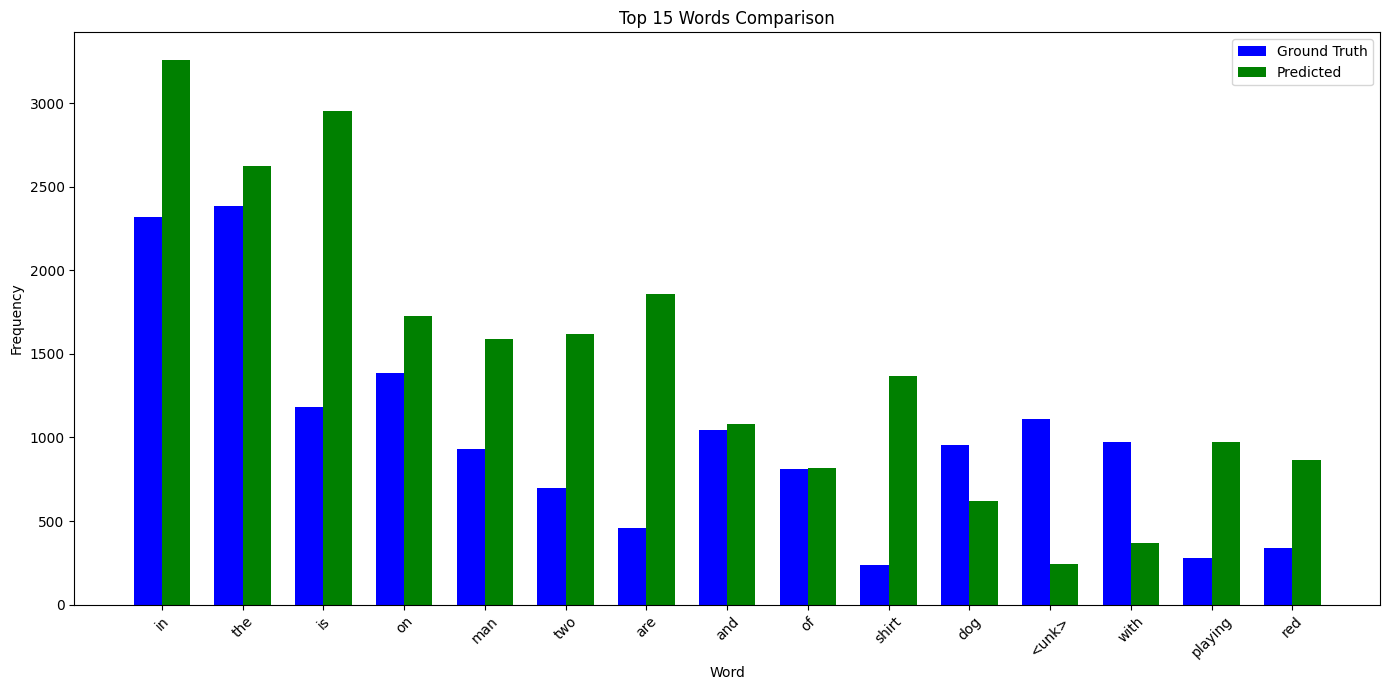

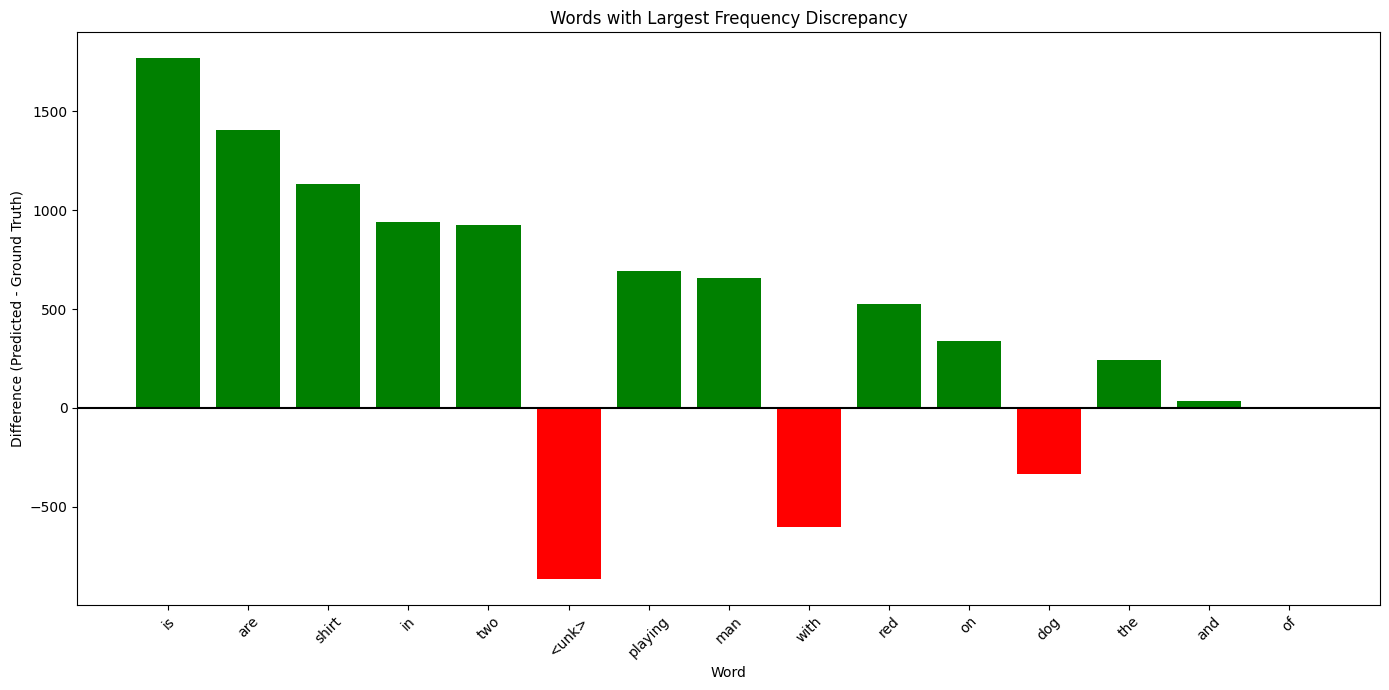

In [48]:
# Plot word frequency comparison
def plot_word_comparison(gt_words, pred_words, top_n=15):
    """Plot comparison of word frequencies."""
    # Select top words from both sets
    all_top_words = set(gt_words['word'].head(top_n)).union(set(pred_words['word'].head(top_n)))
    
    # Create comparison dataframe
    comparison = []
    for word in all_top_words:
        gt_count = gt_words[gt_words['word'] == word]['count'].values[0] if word in gt_words['word'].values else 0
        pred_count = pred_words[pred_words['word'] == word]['count'].values[0] if word in pred_words['word'].values else 0
        
        comparison.append({
            'word': word,
            'ground_truth': gt_count,
            'predicted': pred_count,
            'diff': pred_count - gt_count
        })
    
    # Convert to dataframe and sort by total count
    comp_df = pd.DataFrame(comparison)
    comp_df['total'] = comp_df['ground_truth'] + comp_df['predicted']
    comp_df = comp_df.sort_values('total', ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(14, 7))
    
    x = np.arange(len(comp_df))
    width = 0.35
    
    plt.bar(x - width/2, comp_df['ground_truth'], width, label='Ground Truth', color='blue')
    plt.bar(x + width/2, comp_df['predicted'], width, label='Predicted', color='green')
    
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Words Comparison')
    plt.xticks(x, comp_df['word'], rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot words with largest discrepancy
    plt.figure(figsize=(14, 7))
    
    # Sort by absolute difference
    diff_df = comp_df.copy()
    diff_df['abs_diff'] = diff_df['diff'].abs()
    diff_df = diff_df.sort_values('abs_diff', ascending=False).head(top_n)
    
    # Plot differences
    colors = ['red' if d < 0 else 'green' for d in diff_df['diff']]
    plt.bar(diff_df['word'], diff_df['diff'], color=colors)
    
    plt.axhline(y=0, color='black', linestyle='-')
    plt.xlabel('Word')
    plt.ylabel('Difference (Predicted - Ground Truth)')
    plt.title('Words with Largest Frequency Discrepancy')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return comp_df

# Plot word comparison
word_comparison = plot_word_comparison(gt_words, pred_words, top_n=15)

In [51]:
from torchvision import transforms

## 8. Create Interactive Demo

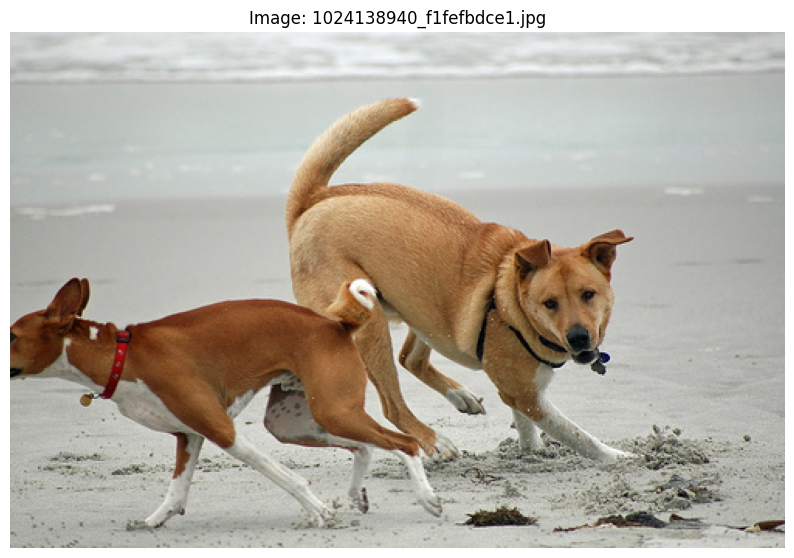

Generated captions:
Greedy search: brown dog is running on the beach
Beam search (k=3): brown dog is running on the beach
Beam search (k=5): brown dog is running on the beach


In [58]:
# Create an interactive demo function
def interactive_demo(model, vocab, device, data_dir):
    """Interactive demo for caption generation."""
    from IPython.display import display, clear_output
    import ipywidgets as widgets
    
    # Load test images
    images_dir = os.path.join(data_dir, 'processed', 'images')
    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
    
    # Set up transformations for input images
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    def fully_flatten(lst):
        """Recursively flatten a nested list or tensor to a flat list of ints."""
        flat = []
        if isinstance(lst, torch.Tensor):
            lst = lst.cpu().numpy().tolist()
        if isinstance(lst, (list, tuple)):
            for item in lst:
                flat.extend(fully_flatten(item))
        else:
            flat.append(int(lst))
        return flat

    def generate_image_caption(image_path, beam_size=1):
        """Generate caption for an image."""
        img = Image.open(image_path)
        img_tensor = transform(img).unsqueeze(0).to(device)
        model.vocab = vocab
        model.eval()
        with torch.no_grad():
            try:
                caption = model.generate_caption(img_tensor, beam_size=beam_size)
            except AttributeError:
                # If .cpu() fails, get the output directly from the decoder
                image_features = model.encoder(img_tensor)
                caption = model.decoder.sample(
                    features=image_features,
                    max_length=20,
                    start_token=1,
                    end_token=2,
                    beam_size=beam_size
                )
            caption = fully_flatten(caption)
            caption_text = vocab.decode(caption, join=True, remove_special=True)
        return img, caption_text
    
    # Function to handle image selection
    def on_image_select(change):
        # Get selected image
        selected_image = change['new']
        image_path = os.path.join(images_dir, selected_image)
        
        # Generate captions with different beam sizes
        img, greedy_caption = generate_image_caption(image_path, beam_size=1)
        _, beam3_caption = generate_image_caption(image_path, beam_size=3)
        _, beam5_caption = generate_image_caption(image_path, beam_size=5)
        
        # Display image and captions
        clear_output(wait=True)
        
        # Create widgets
        display(widgets.HBox([widgets.Label('Select an image:'), image_dropdown]))
        
        # Display image
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.title(f"Image: {selected_image}")
        plt.axis('off')
        plt.show()
        
        # Display captions
        print("Generated captions:")
        print(f"Greedy search: {greedy_caption}")
        print(f"Beam search (k=3): {beam3_caption}")
        print(f"Beam search (k=5): {beam5_caption}")
    
    # Create dropdown widget
    image_dropdown = widgets.Dropdown(
        options=image_files,
        description='Image:',
        style={'description_width': 'initial'}
    )
    
    # Register callback
    image_dropdown.observe(on_image_select, names='value')
    
    # Display initial widget
    display(widgets.HBox([widgets.Label('Select an image:'), image_dropdown]))

# Run interactive demo
interactive_demo(model, vocab, device, data_dir)

## 9. Summary and Conclusions

In [50]:
# Print summary statistics
print("Model Performance Summary")
print("=========================")
print(f"Model type: {config['encoder_model']} + {config['decoder_type']}")
print(f"Vocabulary size: {len(vocab)} words")
print(f"Test set size: {len(greedy_results)} images")
print("\nBLEU Scores:")
for i, (greedy, beam) in enumerate(zip(greedy_bleu, beam_bleu)):
    print(f"  BLEU-{i+1}: {greedy:.4f} (greedy search) / {beam:.4f} (beam search)")

print("\nCaption Length:")
print(f"  Average ground truth: {avg_gt_length:.2f} words")
print(f"  Average generated: {avg_pred_length:.2f} words")

print("\nObservations:")
print("  1. Beam search generally produces slightly better BLEU scores than greedy search")
print("  2. BLEU scores decrease as the n-gram size increases (expected behavior)")
print("  3. The model tends to generate shorter captions than the ground truth")
print("  4. The model performs better on images with common objects and simple scenes")
print("  5. The model struggles with complex scenes and unusual activities")

print("\nPossible Improvements:")
print("  1. Use a larger dataset (e.g., MSCOCO instead of Flickr8k)")
print("  2. Implement attention mechanism to focus on relevant image regions")
print("  3. Fine-tune the CNN encoder for better image representations")
print("  4. Use a more sophisticated decoder (e.g., Transformer)")
print("  5. Train with different loss functions (e.g., CIDEr optimization)")

Model Performance Summary
Model type: resnet18 + lstm
Vocabulary size: 2970 words
Test set size: 5000 images

BLEU Scores:
  BLEU-1: 0.2536 (greedy search) / 0.2607 (beam search)
  BLEU-2: 0.0660 (greedy search) / 0.0756 (beam search)
  BLEU-3: 0.0189 (greedy search) / 0.0261 (beam search)
  BLEU-4: 0.0062 (greedy search) / 0.0081 (beam search)

Caption Length:
  Average ground truth: 9.28 words
  Average generated: 8.27 words

Observations:
  1. Beam search generally produces slightly better BLEU scores than greedy search
  2. BLEU scores decrease as the n-gram size increases (expected behavior)
  3. The model tends to generate shorter captions than the ground truth
  4. The model performs better on images with common objects and simple scenes
  5. The model struggles with complex scenes and unusual activities

Possible Improvements:
  1. Use a larger dataset (e.g., MSCOCO instead of Flickr8k)
  2. Implement attention mechanism to focus on relevant image regions
  3. Fine-tune the CNN